In [1]:
# from pyincore import IncoreClient, DataService, SpaceService, HazardService, Dataset, FragilityService, Mapping, MappingSet, FragilityCurveSet, GeoUtil, Flood, NetworkDataset, NetworkUtil
from pyincore import IncoreClient, Dataset, FragilityService, Mapping, MappingSet, FragilityCurveSet
from pyincore.analyses.buildingdamage import BuildingDamage
# from pyincore.analyses.meandamage import MeanDamage
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 

from pyincore_viz.plotutil import PlotUtil as plot
from pyincore_viz.geoutil import GeoUtil as viz

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import norm, lognorm
import os
import json
import rasterio
import networkx as nx
import contextily as cx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from rasterio.features import geometry_mask
from shapely.geometry import Point, LineString, box
# from shapely.ops import nearest_points

In [2]:
from utility_functions import *

In [3]:
client = IncoreClient()
# data_services = DataService(client)
# space_services = SpaceService(client)
# fragility_services = FragilityService(client)
# hazardsvc = HazardService(client)

Enter username:  sum223
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.19.0


## Input Building Data

In [4]:
buildings_local = Dataset.from_file("sample_buildings.shp", data_type="ergo:buildingInventoryVer4")
buildings_df = buildings_local.get_dataframe_from_shapefile()
buildings_df.head(3)

ID Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
0   1     House1  38.980200 -76.485999           0       2      30      RES3   
1   2     House2  38.979932 -76.485676           0       2      30      RES3   
2   3     House3  38.979717 -76.485350           0       2      30      RES3   

                     geometry  
0     POINT (-76.486 38.9802)  
1  POINT (-76.48568 38.97993)  
2  POINT (-76.48535 38.97972)

In [82]:
# ax = buildings_df.plot(figsize=(20, 10), color = 'Red', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

## Input Substation Data

In [6]:
substations_local = Dataset.from_file("sample_substations.shp", data_type="ergo:buildingInventoryVer4")
substations_df = substations_local.get_dataframe_from_shapefile()
substations_df

ID  Latitude  Longitude Utility Pr                         Buildings  \
0   1  38.99117 -76.491168        BGE  1,2,3,4,5,6,7,8,9,10,11,12,13,14   

                     geometry  
0  POINT (-76.49117 38.99117)

## Substation-Building Graph Object

A graph object is created with nodes at substations and buildings, connecting each substation to the buildings it serves.

In [7]:
edges_bldg_subs_df = pd.read_csv('subs_to_bldgs_edges.csv')

In [8]:
edges_bldg_subs_df

Unnamed: 0  inode_substation  jnode_building
0            0                 1               1
1            1                 1               2
2            2                 1               3
3            3                 1               4
4            4                 1               5
5            5                 1               6
6            6                 1               7
7            7                 1               8
8            8                 1               9
9            9                 1              10
10          10                 1              11
11          11                 1              12
12          12                 1              13
13          13                 1              14

## Input Transportation Network Data

In [9]:
# get link dataset from data service
node_dataset = Dataset.from_file("files/nodes.shp", data_type="ergo:nodeInventoryVer1")
nodes_df = node_dataset.get_dataframe_from_shapefile()

# get link dataset from data service
edge_dataset = Dataset.from_file("files/edges.shp", data_type="ergo:edgeInventoryVer1")
edge_df = edge_dataset.get_dataframe_from_shapefile()

In [10]:
nodes_df = nodes_df.rename(columns = {'osmid': 'nodenwid'})
edge_df = edge_df.rename(columns = {'osmid': 'linknwid',
                           'u': 'fromnode',
                           'v': 'tonode'})

g = create_networkx_graph(nodes_df, edge_df)

## Import Elevation Data

The elevation map is saved in the form of a raster file that can be read into the Notebook and the values of the raster can be attached to the individual structural locations based on proximity.

In [11]:
raster_path = 'files/USGS_1_n39w077_20220713.tif'

buildings_df = attach_flood_hazard(buildings_df, 
                                   raster_path, 
                                   raster_value = 'elevation')

substations_df = attach_flood_hazard(substations_df, 
                                     raster_path, 
                                     raster_value = 'elevation')

## Input Hazard Data

The hazard map is saved in the form of a raster file that can be read into the Notebook and the values of the raster can be attached to the individual structural locations based on proximity.

In [12]:
raster_path = 'files/cat4_high_raster.tif'

buildings_df = attach_flood_hazard(buildings_df, raster_path, raster_value = 'water_depth')
buildings_df['inundationDepth'] = buildings_df['water_depth'] - buildings_df['elevation']
buildings_df['inundationDepth'] = buildings_df['inundationDepth'].apply(lambda x: max(x, 0))
buildings_df.head(3)

ID Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
0   1     House1  38.980200 -76.485999           0       2      30      RES3   
1   2     House2  38.979932 -76.485676           0       2      30      RES3   
2   3     House3  38.979717 -76.485350           0       2      30      RES3   

                     geometry  elevation  water_depth  inundationDepth  
0     POINT (-76.486 38.9802)   2.569192     2.827191         0.257999  
1  POINT (-76.48568 38.97993)   1.930152     2.827191         0.897038  
2  POINT (-76.48535 38.97972)   1.807689     2.827191         1.019502

In [83]:
# # viz.plot_gdf_map(buildings_df, column='inundationDepth')
# ### Plot EPN shapefiles
# ax = buildings_df.plot(figsize=(20, 10), column='inundationDepth', categorical=True, markersize=150, legend=True, cmap = 'Blues')
# cx.add_basemap(ax, crs=nodes_df.crs)

In [14]:
substations_df = attach_flood_hazard(substations_df, raster_path, raster_value = 'water_depth')
substations_df['inundationDepth'] = substations_df['water_depth'] - substations_df['elevation']
substations_df['inundationDepth'] = substations_df['inundationDepth'].apply(lambda x: max(x, 0))
substations_df

ID  Latitude  Longitude Utility Pr                         Buildings  \
0   1  38.99117 -76.491168        BGE  1,2,3,4,5,6,7,8,9,10,11,12,13,14   

                     geometry  elevation  water_depth  inundationDepth  
0  POINT (-76.49117 38.99117)   2.206628    14.029014        11.822386

In [15]:
nodes_df = attach_flood_hazard(nodes_df, raster_path)
nodes_df.head(3)

# edge_df = attach_flood_hazard(edge_df, raster_path)
# edge_df

nodenwid          y          x highway   ref                    geometry  \
0  7185334298  38.985016 -76.487252    None  None  POINT (-76.48725 38.98502)   
1   102629495  38.992313 -76.499406    None  None  POINT (-76.49941 38.99231)   
2   102629499  38.990768 -76.501229    None  None  POINT (-76.50123 38.99077)   

   inundationDepth  
0        14.029014  
1         3.067575  
2         0.000000

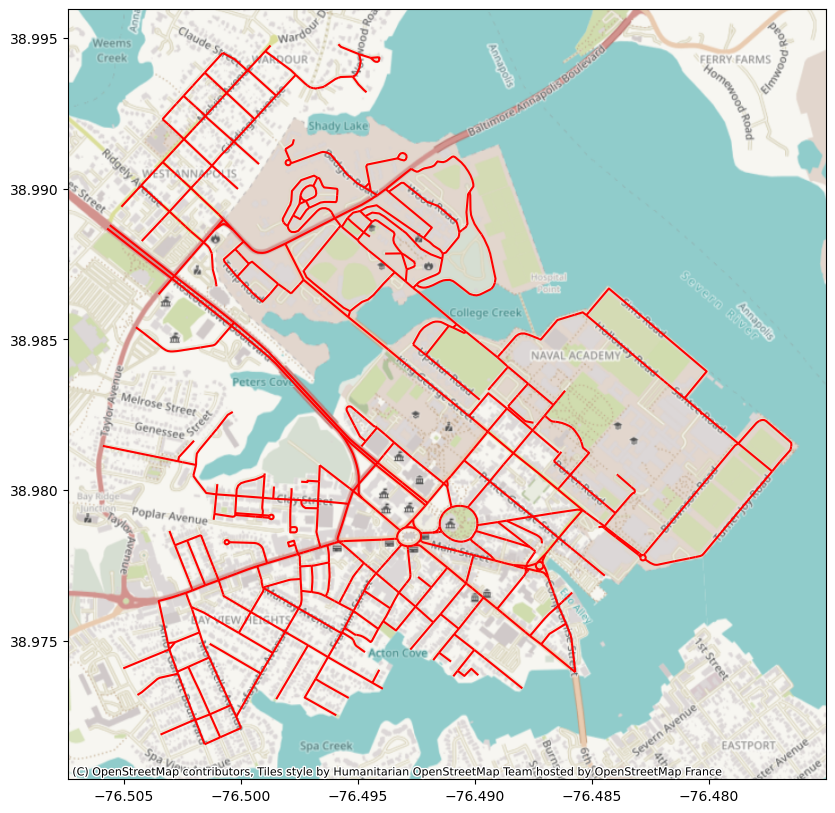

In [85]:
### Plot Transportation Network shapefiles
# ax = nodes_df.plot(figsize=(20, 10), column='inundationDepth', categorical=True, markersize=20, legend=True, cmap = 'Blues')
ax = edge_df.plot(figsize=(20, 10), color='r')
cx.add_basemap(ax, crs=nodes_df.crs)

## Fragility Model Definition

### Buildings

In [17]:
fragility_curve_set1, fragility_curve_set2, local_building_mapping_set = get_building_fragility()

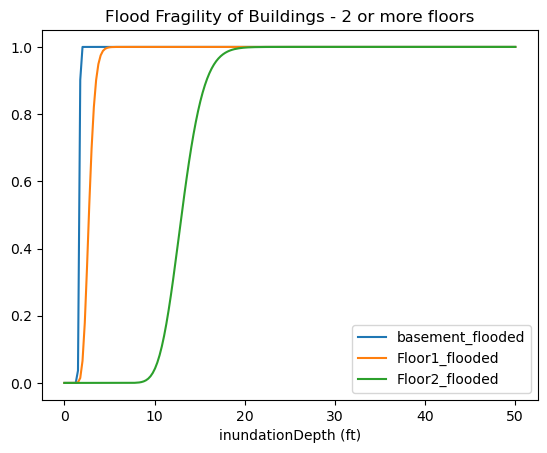

In [18]:
plt = plot.get_fragility_plot(fragility_curve_set1, start=0, end=50)

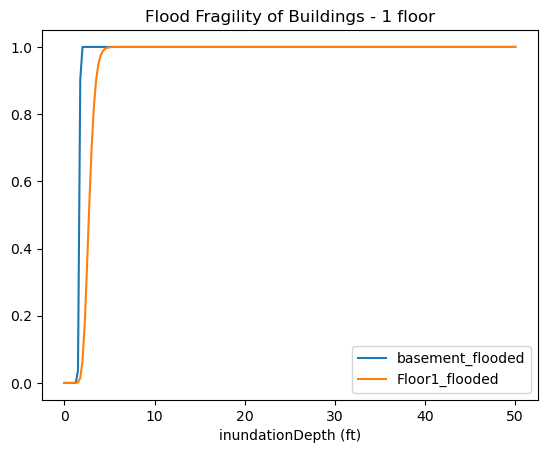

In [19]:
plt = plot.get_fragility_plot(fragility_curve_set2, start=0, end=50)

### Substations

In [20]:
fragility_curve_set_substations = get_substation_fragility()

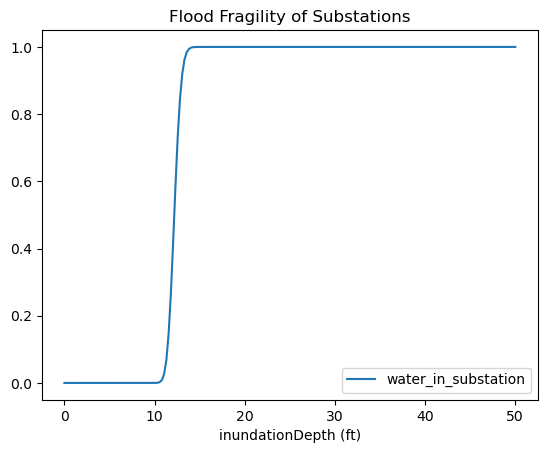

In [21]:
plt = plot.get_fragility_plot(fragility_curve_set_substations, start=0, end=50)

### Roads

In [22]:
fragility_curve_set_roads = get_road_fragility()

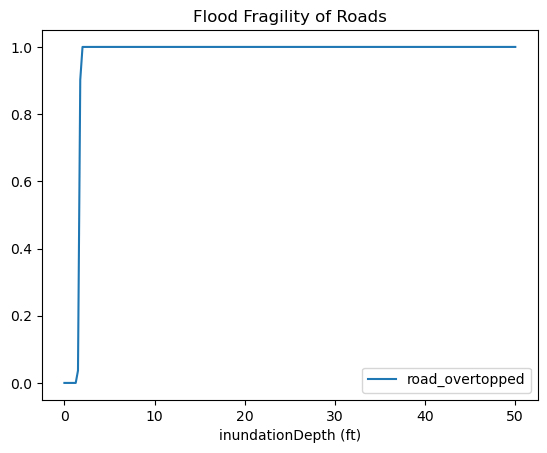

In [23]:
plt = plot.get_fragility_plot(fragility_curve_set_roads, start=0, end=50)

## Perform Damage Analysis

### Buildings

In [24]:
buildings_df = run_building_damage_analysis(buildings_df, local_building_mapping_set)
buildings_df.head(3)

ID Building_n   Latitude  Longitude  Base_eleva  Floors  Height Occupancy  \
0   1     House1  38.980200 -76.485999           0       2      30      RES3   
1   2     House2  38.979932 -76.485676           0       2      30      RES3   
2   3     House3  38.979717 -76.485350           0       2      30      RES3   

                     geometry  elevation  water_depth  inundationDepth  LS_0  \
0     POINT (-76.486 38.9802)   2.569192     2.827191         0.257999   0.0   
1  POINT (-76.48568 38.97993)   1.930152     2.827191         0.897038   0.0   
2  POINT (-76.48535 38.97972)   1.807689     2.827191         1.019502   0.0   

           LS_1  LS_2  DS_0          DS_1          DS_2  DS_3  
0  0.000000e+00   0.0   1.0  0.000000e+00  0.000000e+00   0.0  
1  1.480000e-08   0.0   1.0 -1.480000e-08  1.480000e-08   0.0  
2  4.709000e-07   0.0   1.0 -4.709000e-07  4.709000e-07   0.0

In [81]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_2', legend=True, cmap = 'Reds', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

### Substations

In [26]:
substations_df = run_substation_damage_analysis(substations_df, fragility_curve_set_substations)

In [27]:
substations_df

ID  Latitude  Longitude Utility Pr                         Buildings  \
0   1  38.99117 -76.491168        BGE  1,2,3,4,5,6,7,8,9,10,11,12,13,14   

                     geometry  elevation  water_depth  inundationDepth  \
0  POINT (-76.49117 38.99117)   2.206628    14.029014        11.822386   

       LS_0      DS_0      DS_1  
0  0.274219  0.725781  0.274219

### Buildings Power

In [28]:
buildings_df = run_buildings_power(substations_df, buildings_df, edges_bldg_subs_df)

In [80]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_power', legend=True, cmap = 'Reds', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

### Roads

In [30]:
edge_df = run_road_damage_analysis(edge_df, fragility_curve_set_roads)

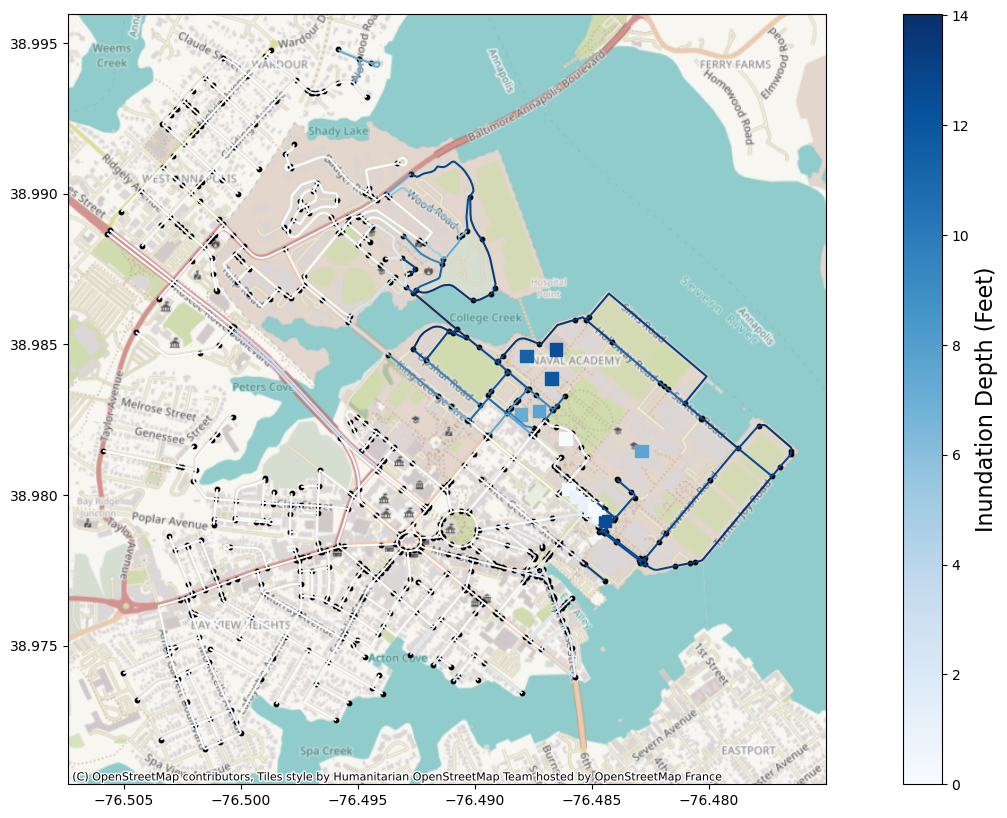

In [86]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.Blues
norm = mcolors.Normalize(vmin=0.0, vmax=edge_df['inundationDepth'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='inundationDepth', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='inundationDepth', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Inundation Depth (Feet)", fontsize=16)
# ax.set_title('Map Showing Probability of Failure for Roads and Probability of 1st Floor Flooding in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)

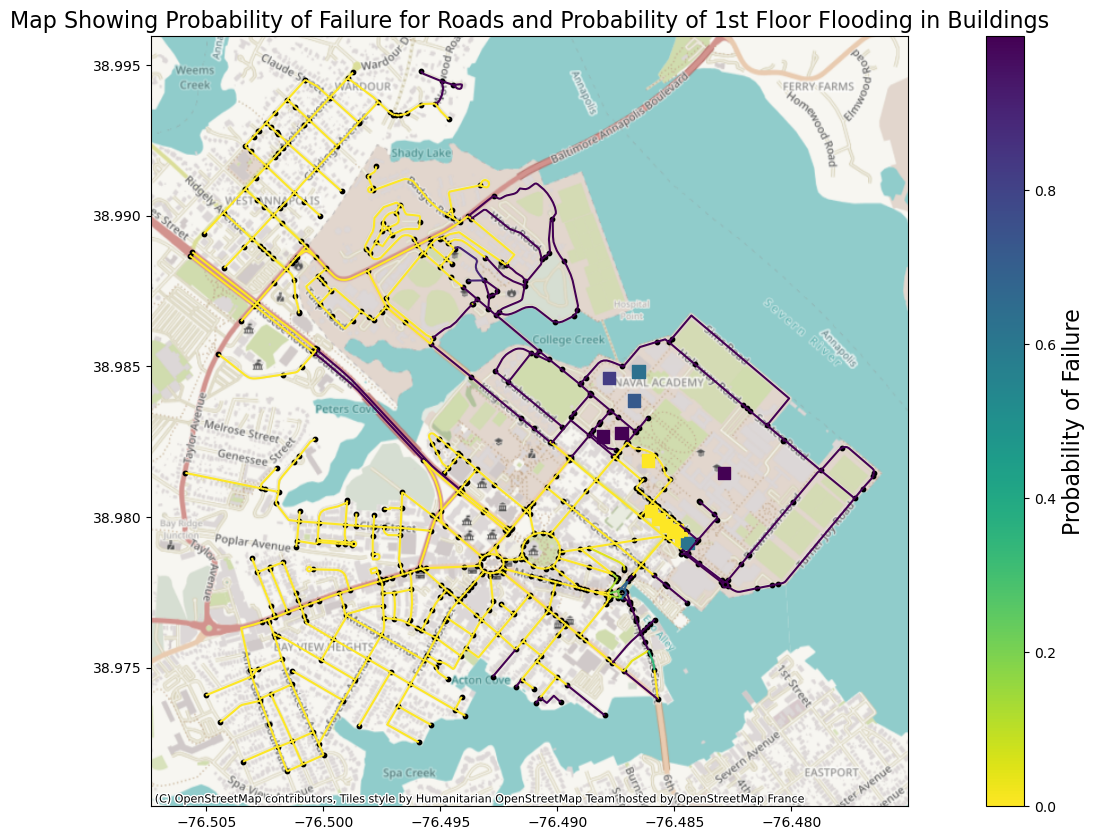

In [71]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['DS_2'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='DS_1', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='DS_2', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Probability of Failure", fontsize=16)
ax.set_title('Map Showing Probability of Failure for Roads and Probability of 1st Floor Flooding in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

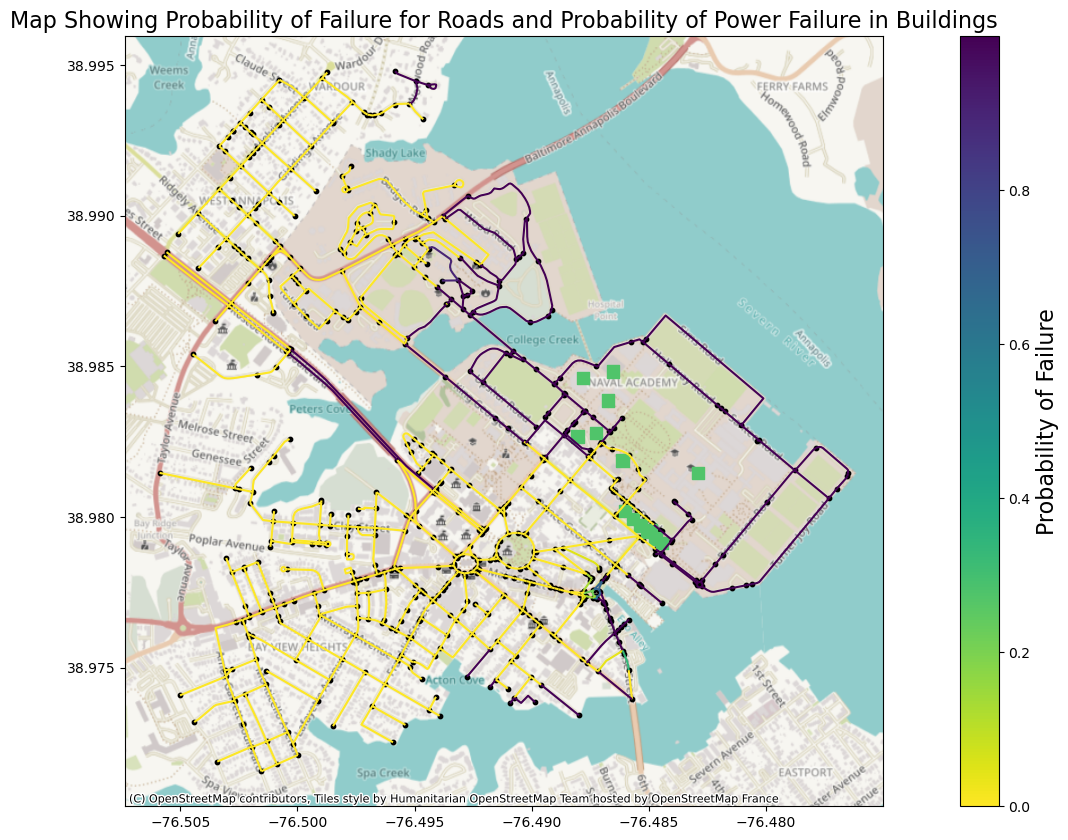

In [72]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['DS_2'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='DS_1', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='DS_power', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Probability of Failure", fontsize=16)
ax.set_title('Map Showing Probability of Failure for Roads and Probability of Power Failure in Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

## Monte Carlo Simulation

In [34]:
num_samples = 100

### Building Failure Simulations

In [35]:
buildings_df_mc = montecarloFailureSim(buildings_df.copy(), 
                                   ["DS_0", "DS_1", "DS_2", "DS_3"],
                                   num_samples)

### Building Power Failure Simulations

In [36]:
buildings_df_mc = montecarloFailureSim(buildings_df.copy(), 
                                   ["DS_nopower", "DS_power"],
                                   num_samples)

### Transportation Failure Simulations

In [37]:
edge_df_mc = montecarloFailureSim(edge_df.copy(), 
                               ["DS_0", "DS_1"],
                               num_samples)

## Network Resilience Metric Computation

In [38]:
# Create Networkx graph object from nodes and edges database
G = create_networkx_graph(nodes_df, edge_df)

In [39]:
### Add nearest network node ID to buildings GeoDataFrame
buildings_df['nearest_node'] = buildings_df.apply(
    lambda row: find_nearest_network_node(row, nodes_df), axis=1
)

building_nodes = np.array(nodes_df.loc[buildings_df['nearest_node'], 'nodenwid'])

# Identify the edge nodes in the network
boundary_nodes = np.array([node for node, degree in G.degree() if degree == 1])
boundary_nodes = boundary_nodes[~np.isin(boundary_nodes, building_nodes)]

In [40]:
results_pristine = compute_shortest_paths(G, building_nodes, boundary_nodes)
efficiency_pristine = (1 / results_pristine['Weight'].replace([float('inf'), -float('inf')], float('nan'))).sum()

In [41]:
resilience_metric = []
for simnum in range(num_samples):
    edge_df_mc['sample'] =edge_df_mc.iloc[:, -1].apply(lambda x: x[simnum] if x else None)
    edge_df_mc = edge_df_mc[edge_df_mc['sample'] != 1].reset_index(drop = True)

    G_temp = create_networkx_graph(nodes_df, edge_df_mc)
    # results = compute_shortest_paths(G_temp, building_nodes, boundary_nodes)
    # edge_df_mc = edge_df_mc.drop(columns = ['sample'])
    # efficiency = (1 / results['Weight'].replace([float('inf'), -float('inf')], float('nan'))).sum()

    # relative_efficiency = efficiency/efficiency_pristine
    relative_connectivity = count_connected_pairs(G_temp)
    
    # resilience_metric.append(relative_efficiency)
    resilience_metric.append(relative_connectivity)
    del G_temp
    

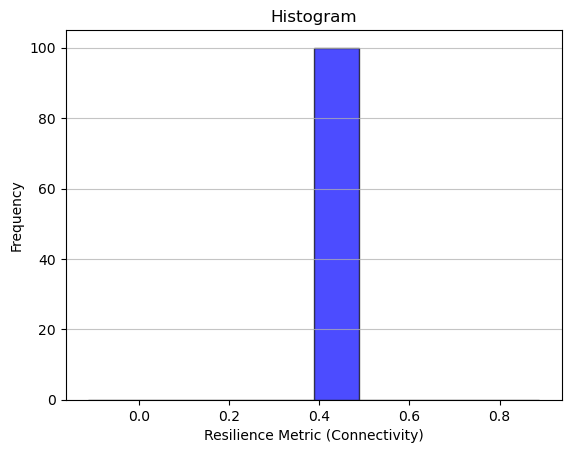

In [42]:
plt.hist(resilience_metric, bins = 10, color = 'blue', edgecolor = 'black', alpha = 0.7)
# Customize the plot
plt.title('Histogram')
plt.xlabel('Resilience Metric (Connectivity)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show plot
plt.show()

## Recovery Models

In [48]:
# buildings_df = building_recovery_model(buildings_df)
# buildings_df = building_power_recovery_model(buildings_df)
# edge_df = road_recovery_model(edge_df)

In [49]:
buildings_df = get_recovery_curve_buildings(buildings_df)
buildings_df = get_recovery_curve_power(buildings_df)
edge_df = get_recovery_curve_roads(edge_df)

C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:669: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1840000302409948e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_df.loc[i, 'mean_downtime'] = mean_downtime_days
C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.001650212103381498' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_df.loc[i, 'std_downtime'] = stdev_downtime_days
C:\Users\sum223\Documents\Projects\NAVFAC-Incore\utility_functions.py:723: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8226563349000002' has dtype incompatible with int64, ple

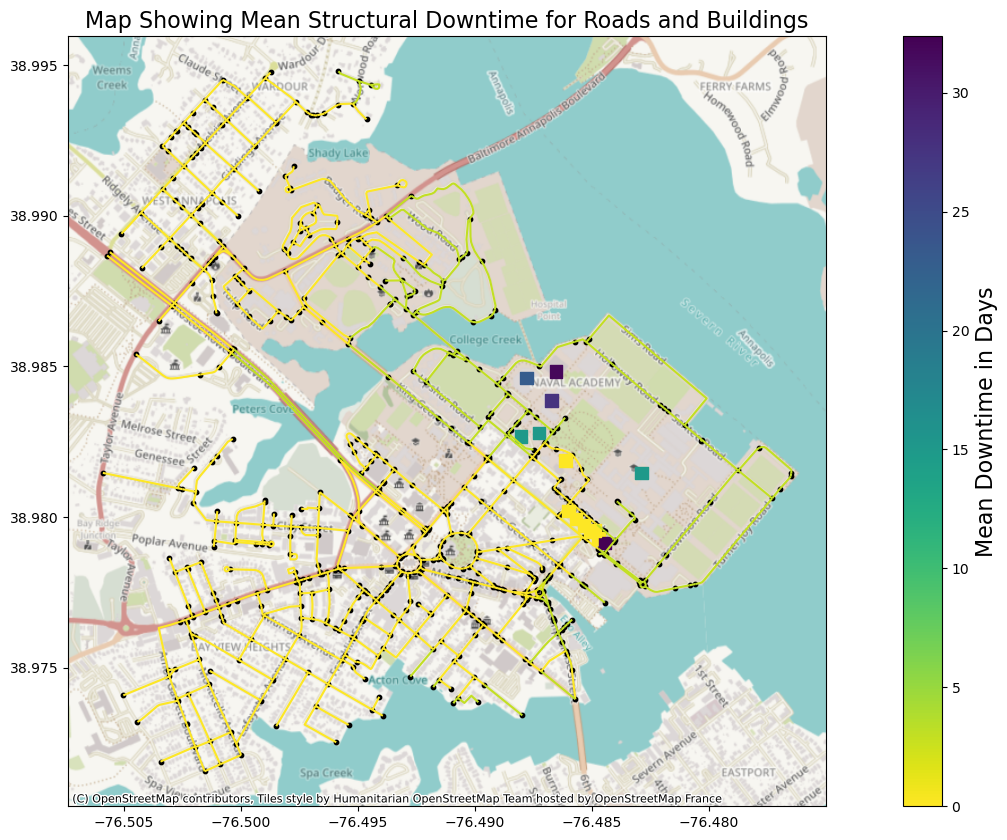

In [75]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=buildings_df['mean_downtime'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='mean_downtime', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='mean_downtime', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Mean Downtime in Days", fontsize=16)
ax.set_title('Map Showing Mean Structural Downtime for Roads and Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)
                

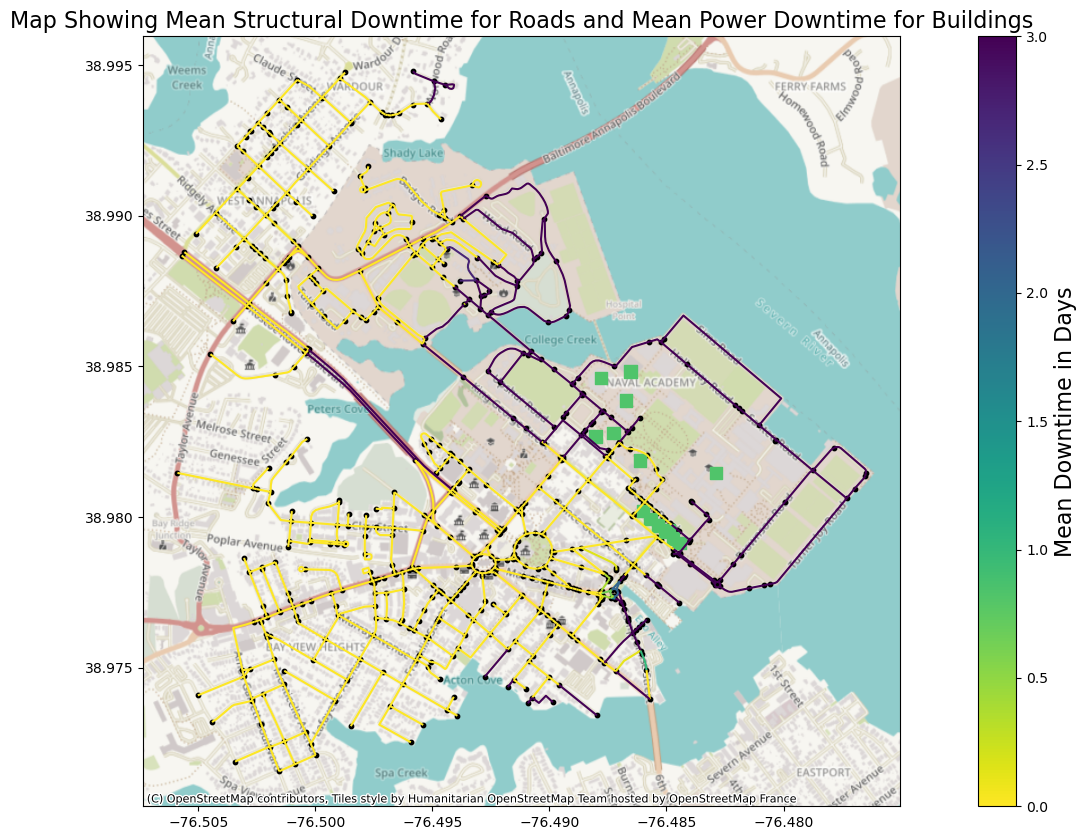

In [77]:
### Plot Transportation Network shapefiles

# Define colormap
cmap = cm.viridis_r
norm = mcolors.Normalize(vmin=0.0, vmax=edge_df['mean_downtime'].max())

ax = nodes_df.plot(figsize=(20, 10), color = 'k', markersize=10)
edge_plot = edge_df.plot(ax=ax, column='mean_downtime', legend=False, cmap = cmap, norm = norm)
building_plot = buildings_df.plot(ax=ax, column='mean_downtime_power', marker = 's', markersize=80, legend=False, cmap = cmap, norm = norm)

# Add colorbar manually
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Add label to the colorbar
cbar.set_label("Mean Downtime in Days", fontsize=16)
ax.set_title('Map Showing Mean Structural Downtime for Roads and Mean Power Downtime for Buildings', fontsize = 16)

cx.add_basemap(ax, crs=nodes_df.crs)

In [57]:
# ax = buildings_df.plot(figsize=(20, 10), color = 'Red', marker = 's', markersize=100)
# susb_plot = substations_df.plot(ax=ax, color = 'Blue', marker = 'd', markersize = 100)
# cx.add_basemap(ax, crs=buildings_df.crs)

In [87]:
# ax = buildings_df.plot(figsize=(20, 10), column='DS_power', legend=True, cmap = 'viridis_r', marker = 's', markersize=100)
# cx.add_basemap(ax, crs=buildings_df.crs)

## Additional Plots

### Plot MCS Instances

In [43]:
# Pick any simulation number to showcase
simnum = 53

edge_df_mc['sample'] = edge_df_mc.iloc[:, -1].apply(lambda x: x[simnum] if x else None)
edge_df_mc = edge_df_mc[edge_df_mc['sample'] != 1].reset_index(drop = True)
G_temp = create_networkx_graph(nodes_df, edge_df_mc)

# Convert nodes to GeoDataFrame
node_data = {
    "id": list(G_temp.nodes),
    "geometry": [Point(data["geometry"]) for node, data in G_temp.nodes(data=True)],
}
nodes_gdf = gpd.GeoDataFrame(node_data, crs="EPSG:4326")

# Convert edges to GeoDataFrame
edge_data = {
    "source": [u for u, v, data in G_temp.edges(data=True)],
    "target": [v for u, v, data in G_temp.edges(data=True)],
    "weight": [data["length"] for u, v, data in G_temp.edges(data=True)],
    "geometry": [
        LineString([Point(G_temp.nodes[u]["geometry"]), Point(G_temp.nodes[v]["geometry"])])
        for u, v, data in G_temp.edges(data=True)
    ],
}
edges_gdf = gpd.GeoDataFrame(edge_data, crs="EPSG:4326")



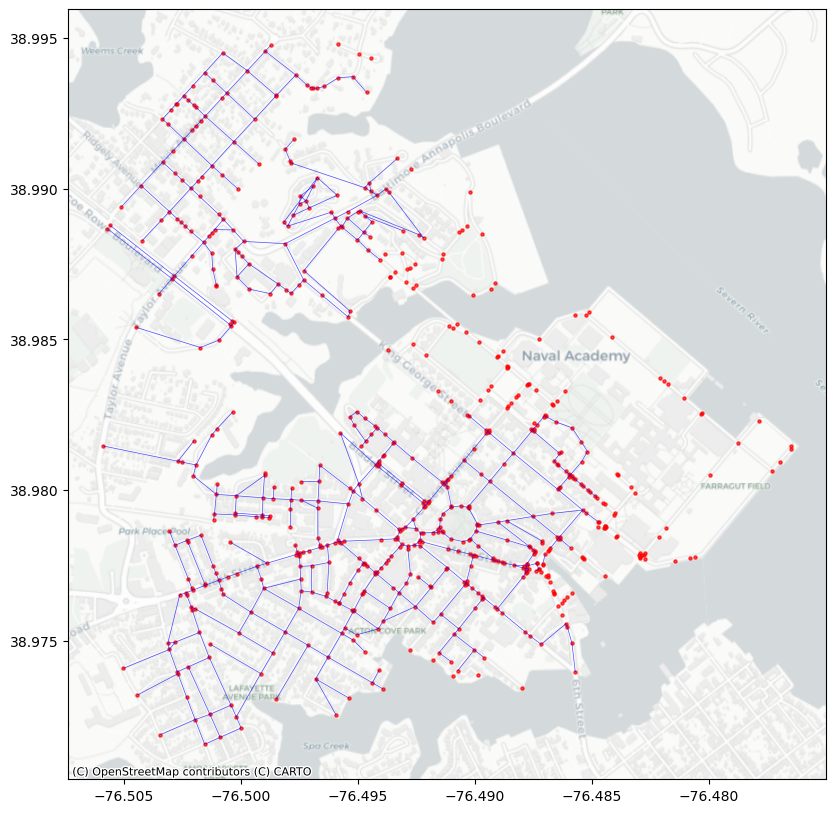

In [44]:
# Plot with basemap
fig, ax = plt.subplots(figsize=(20, 10))
edges_gdf.plot(ax=ax, linewidth=0.5, edgecolor="blue", alpha=0.7)
nodes_gdf.plot(ax=ax, markersize=5, color="red", alpha=0.7)

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nodes_gdf.crs)

plt.show()

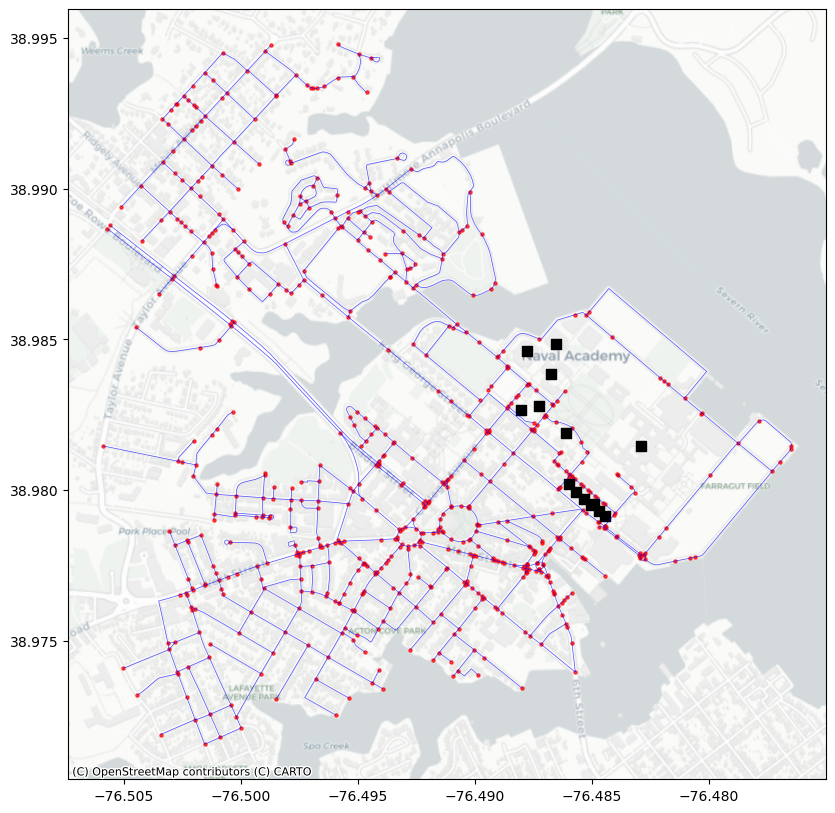

In [45]:
# Plot with basemap
fig, ax = plt.subplots(figsize=(20, 10))
edge_df.plot(ax=ax, linewidth=0.5, edgecolor="blue", alpha=0.7)
nodes_df.plot(ax=ax, markersize=5, color="red", alpha=0.7)
building_plot = buildings_df.plot(ax=ax, marker = 's', markersize=50, color = 'k')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=nodes_gdf.crs)

plt.show()

### Plot Recovery Curves

#### Aggregated Recovery Curve

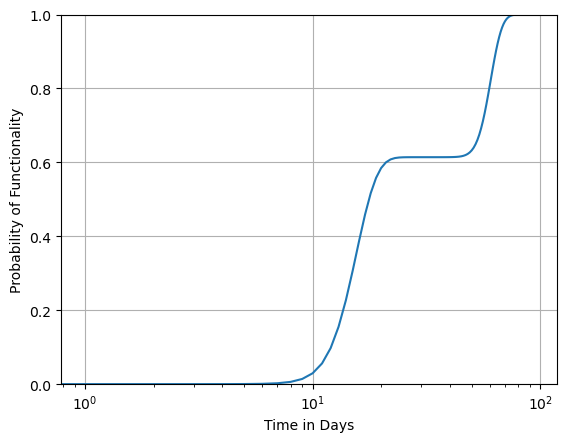

In [89]:
building_id = 5
time = buildings_df.loc[building_id, 'time']
functionality = buildings_df.loc[building_id, 'recov']

plt.xscale('log')
plt.plot(time, functionality)
plt.grid(True)
plt.ylim(0,1)
plt.xlim(0,np.max(time))
plt.xlabel('Time in Days')
plt.ylabel('Probability of Functionality')
# plt.legend()

plt.show()